In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from configuration import constants

HEALTHY = constants.HEALTHY
INFECTED = constants.INFECTED
SUSCEPTIBLE = constants.SUSCEPTIBLE
CURED = constants.CURED
DEAD = constants.DEAD
INFANT_DEATH = constants.INFANT_DEATH
CHILD_DEATH = constants.CHILD_DEATH
HBV_DEATH = constants.HBV_DEATH
MATERNAL_DEATH = constants.MATERNAL_DEATH

In [48]:
import cPickle
from os.path import join

def collect_multi_run_stats(folder):
    
    with open(join(folder, 'collective_mother_stats.pkl'), 'rb') as f:
        mother_stats_config = cPickle.load(f)

    with open(join(folder, 'collective_children_stats.pkl'), 'rb') as f:
        children_stats_config = cPickle.load(f)
        
    return mother_stats_config, children_stats_config

mother_config_1, children_config_1 = collect_multi_run_stats('config_1')
mother_config_2, children_config_2 = collect_multi_run_stats('config_2')
mother_config_3, children_config_3 = collect_multi_run_stats('config_3')

In [49]:
def plot_yearly_stat(yearly_stats, xlabels, ylabels, title):
    
    fig, ax = plt.subplots(figsize=(14,5))
    x_ticks = len(years)
    idx = np.arange(x_ticks)
    width = 0.35

    for idx in range(0, yearly_stats.shape[0]):
        ax.plot(xlabels, yearly_stats[idx,:], label=ylabels[idx] )
    
    ax.set_xlabel('years')
    ax.set_ylabel('population')
    ax.legend(loc='best')
    fig.suptitle(title)
    plt.show()

In [85]:
def collect_yearly_stats(stat_collection, status, years):
    yearly_stats = list() #np.zeros((len(mother_status), len(years)))
    for m_idx, m in enumerate(status):
        for y_idx, y in enumerate(years):
            yearly_stats.append(stat_collection[m][y][1:])
    return yearly_stats

def plot_yearly_stats(yearly_stats, years):
    
    number_configs = len(yearly_stats)
    
    grid = GridSpec(1,number_configs)
    
    year_label = [str(yr+2018) for yr in years]
    print year_label
    
    fig = plt.figure(figsize=(15,5))
    for r in range(number_configs):
        
        y_stat = yearly_stats[r]
        y_stat = np.array(y_stat)
        mean_y = np.mean(y_stat, axis = 1)
        std_y = np.std(y_stat, axis=1)
        
        ax = plt.subplot(grid[0,r])
        ax.errorbar(years, mean_y, yerr = std_y, ecolor='red')
        ax.set_xticklabels(year_label)
    return fig

['2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030']


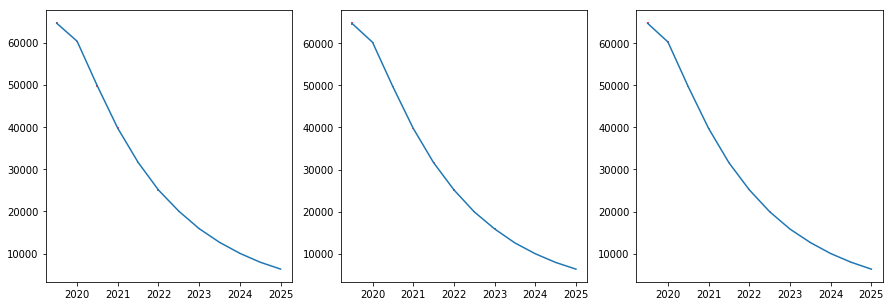

In [87]:
mother_status = [INFECTED] #[HEALTHY, SUSCEPTIBLE, INFECTED, CURED, DEAD, MATERNAL_DEATH]
years = [i for i in range(1,13)]

mother_stats_config_1 = collect_yearly_stats(mother_config_1, mother_status, years)
mother_stats_config_2 = collect_yearly_stats(mother_config_2, mother_status, years)
mother_stats_config_3 = collect_yearly_stats(mother_config_3, mother_status, years)

info_array = np.array(mother_stats_config_1)

#fig, ax = plt.subplots()
#ax.boxplot(mother_stats_config_1[1:])
_ = plot_yearly_stats([mother_stats_config_1, mother_stats_config_2, mother_stats_config_3], years)

['2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030']


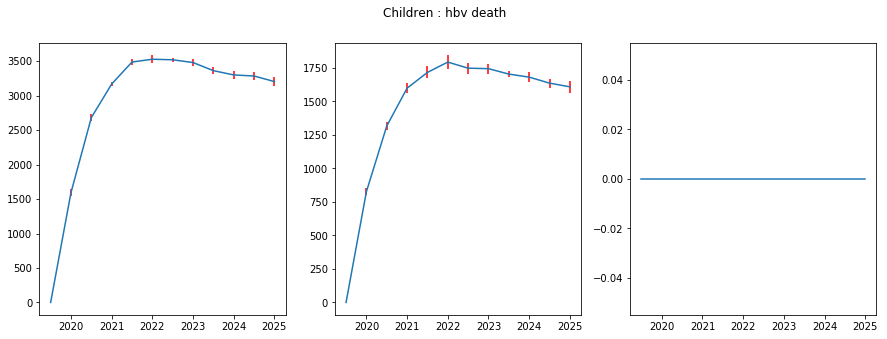

In [83]:
children_status = [HBV_DEATH] #[HEALTHY, INFECTED,SUSCEPTIBLE,CURED, INFANT_DEATH, CHILD_DEATH, HBV_DEATH, DEAD]
years = [i for i in range(1,13)]

children_stats_config_1 = collect_yearly_stats(children_config_1, children_status, years)
children_stats_config_2 = collect_yearly_stats(children_config_2, children_status, years)
children_stats_config_3 = collect_yearly_stats(children_config_3, children_status, years)


for st in children_status:
    fig=plot_yearly_stats([children_stats_config_1, children_stats_config_2, children_stats_config_3], years)
    fig.suptitle('Children : {0}'.format(st))